# 示例：轴承故障诊断

In [1]:
from torch import nn

from rulframework.data.FeatureExtractor import FeatureExtractor
from rulframework.data.label.FaultLabelGenerator import FaultLabelGenerator
from rulframework.data.loader.XJTUDataLoader import XJTUDataLoader
from rulframework.data.processor.RMSProcessor import RMSProcessor
from rulframework.entity.Bearing import BearingFault
from rulframework.model.pytorch.PytorchModel import PytorchModel
from rulframework.data.stage.BearingStageCalculator import BearingStageCalculator
from rulframework.data.stage.eol.NinetyThreePercentRMSEoLCalculator import NinetyThreePercentRMSEoLCalculator
from rulframework.data.stage.fpt.ThreeSigmaFPTCalculator import ThreeSigmaFPTCalculator
from rulframework.model.pytorch.basic.CNN import CNN

from rulframework.util.Plotter import Plotter

# 定义 数据加载器、特征提取器、fpt计算器、eol计算器

In [2]:
data_loader = XJTUDataLoader('D:\\data\\dataset\\XJTU-SY_Bearing_Datasets')
feature_extractor = FeatureExtractor(RMSProcessor(data_loader.continuum))
fpt_calculator = ThreeSigmaFPTCalculator()
eol_calculator = NinetyThreePercentRMSEoLCalculator()
stage_calculator = BearingStageCalculator(fpt_calculator, eol_calculator, data_loader.continuum)

DEBUG - 17:08:04 >> 
>> 数据集位置：D:\data\dataset\XJTU-SY_Bearing_Datasets
  Bearing1_1，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_1
  Bearing1_2，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_2
  Bearing1_3，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_3
  Bearing1_4，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_4
  Bearing1_5，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_5
  Bearing2_1，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_1
  Bearing2_2，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_2
  Bearing2_3，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_3
  Bearing2_4，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_4
  Bearing2_5，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_5
  Bearing3_1，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\40Hz10kN\Bearing3_1
  Bearing3_2，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\40H

# 获取原始数据、特征数据、阶段数据

In [3]:
bearing = data_loader.get("Bearing1_3", 'Horizontal Vibration')
feature_extractor.extract(bearing)
stage_calculator.calculate_state(bearing)

DEBUG - 17:08:04 >> 正在加载数据项：Bearing1_3
DEBUG - 17:08:05 >> 成功加载数据项：Bearing1_3


# 生成训练数据

In [4]:
generator = FaultLabelGenerator(2048, list(BearingFault.__members__.values()), is_onehot=False)
dataset = generator.generate(bearing)

# 通过其他轴承增加训练数据

In [5]:
for bearing_name in ['Bearing1_1', 'Bearing1_4', 'Bearing2_1', 'Bearing1_2', 'Bearing2_3']:
    bearing_train = data_loader.get(bearing_name, 'Horizontal Vibration')
    feature_extractor.extract(bearing_train)
    stage_calculator.calculate_state(bearing_train)
    another_dataset = generator.generate(bearing_train)
    dataset.append(another_dataset)

DEBUG - 17:08:05 >> 正在加载数据项：Bearing1_1
DEBUG - 17:08:06 >> 成功加载数据项：Bearing1_1
DEBUG - 17:08:06 >> 正在加载数据项：Bearing1_4
DEBUG - 17:08:07 >> 成功加载数据项：Bearing1_4
DEBUG - 17:08:08 >> 正在加载数据项：Bearing2_1
DEBUG - 17:08:12 >> 成功加载数据项：Bearing2_1
DEBUG - 17:08:12 >> 正在加载数据项：Bearing1_2
DEBUG - 17:08:14 >> 成功加载数据项：Bearing1_2
DEBUG - 17:08:14 >> 正在加载数据项：Bearing2_3
DEBUG - 17:08:19 >> 成功加载数据项：Bearing2_3


# 划分训练集与测试集

In [6]:
train_set, test_set = dataset.split(0.7)

# 定义模型并训练

INFO - 17:08:20 >> 
>> 成功初始化模型
  当前使用设备：cuda
  模型参数类型：torch.float32
DEBUG - 17:08:21 >> Epoch 1/10, Loss: 0.8549571200
DEBUG - 17:08:22 >> Epoch 2/10, Loss: 0.4721108896
DEBUG - 17:08:22 >> Epoch 3/10, Loss: 0.3162466953
DEBUG - 17:08:23 >> Epoch 4/10, Loss: 0.2422636732
DEBUG - 17:08:23 >> Epoch 5/10, Loss: 0.2146989978
DEBUG - 17:08:24 >> Epoch 6/10, Loss: 0.1866858398
DEBUG - 17:08:24 >> Epoch 7/10, Loss: 0.1848262484
DEBUG - 17:08:25 >> Epoch 8/10, Loss: 0.1688627123
DEBUG - 17:08:25 >> Epoch 9/10, Loss: 0.1889381244
DEBUG - 17:08:26 >> Epoch 10/10, Loss: 0.1713557560


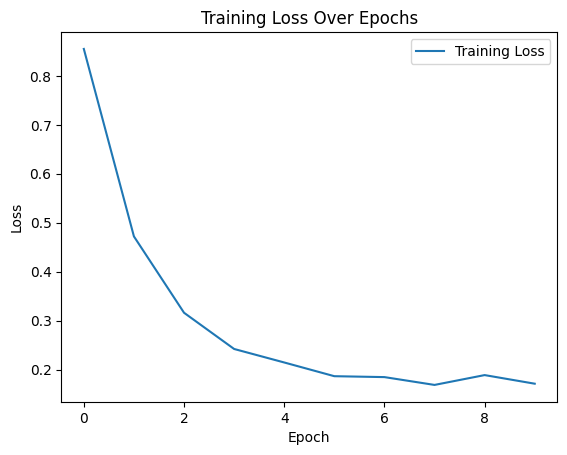

In [7]:
model = PytorchModel(CNN(2048, 5))

model.train(train_set, 10, weight_decay=0.01, criterion=nn.CrossEntropyLoss())
Plotter.loss(model)

# 预测

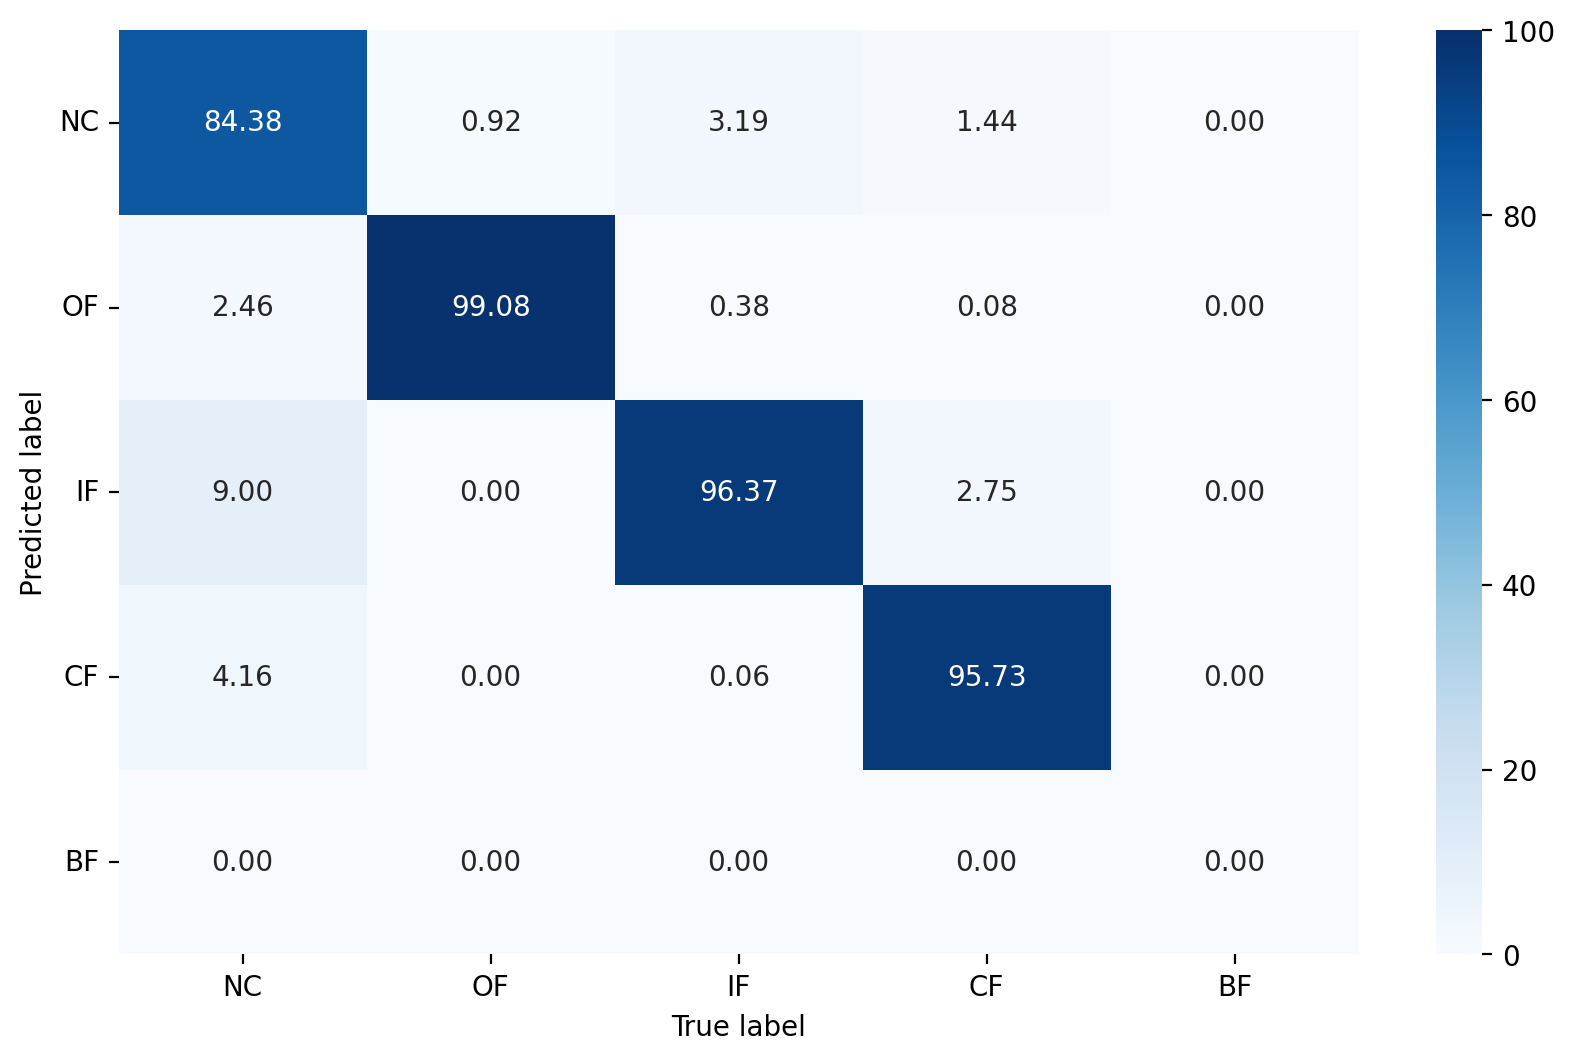

In [8]:
result = model.test(test_set)

Plotter.fault_diagnosis_heatmap(test_set, result)